Загальна кількість: 1000
Тип_вина
0.0    500
1.0    500
Name: count, dtype: int64
   Кислотність  Летка_кислотність  Лимонна_кислота  Залишковий_цукор  \
0     3.439737           0.569968         0.272993          1.164535   
1     3.388939           0.546232         0.294219          1.897730   
2     3.451815           0.502982         0.268303          2.210476   
3     3.521842           0.467653         0.287682          3.821381   
4     3.381268           0.534911         0.224255          2.889587   

    Хлориди  Вільний_SO2  Загальний_SO2  Щільність        pH  Сульфати  \
0  0.076365    12.881202      43.288780   0.997785  3.397358  0.688270   
1  0.084688    12.732929      50.536037   0.995222  3.359708  0.703671   
2  0.085180     6.021784      45.869097   0.997715  3.386210  0.674934   
3  0.089726    13.349549      51.780063   0.996766  3.457179  0.552875   
4  0.071331    18.664145      56.787745   0.997707  3.502229  0.642229   

    Алкоголь  Тип_вина  
0  10.228602   

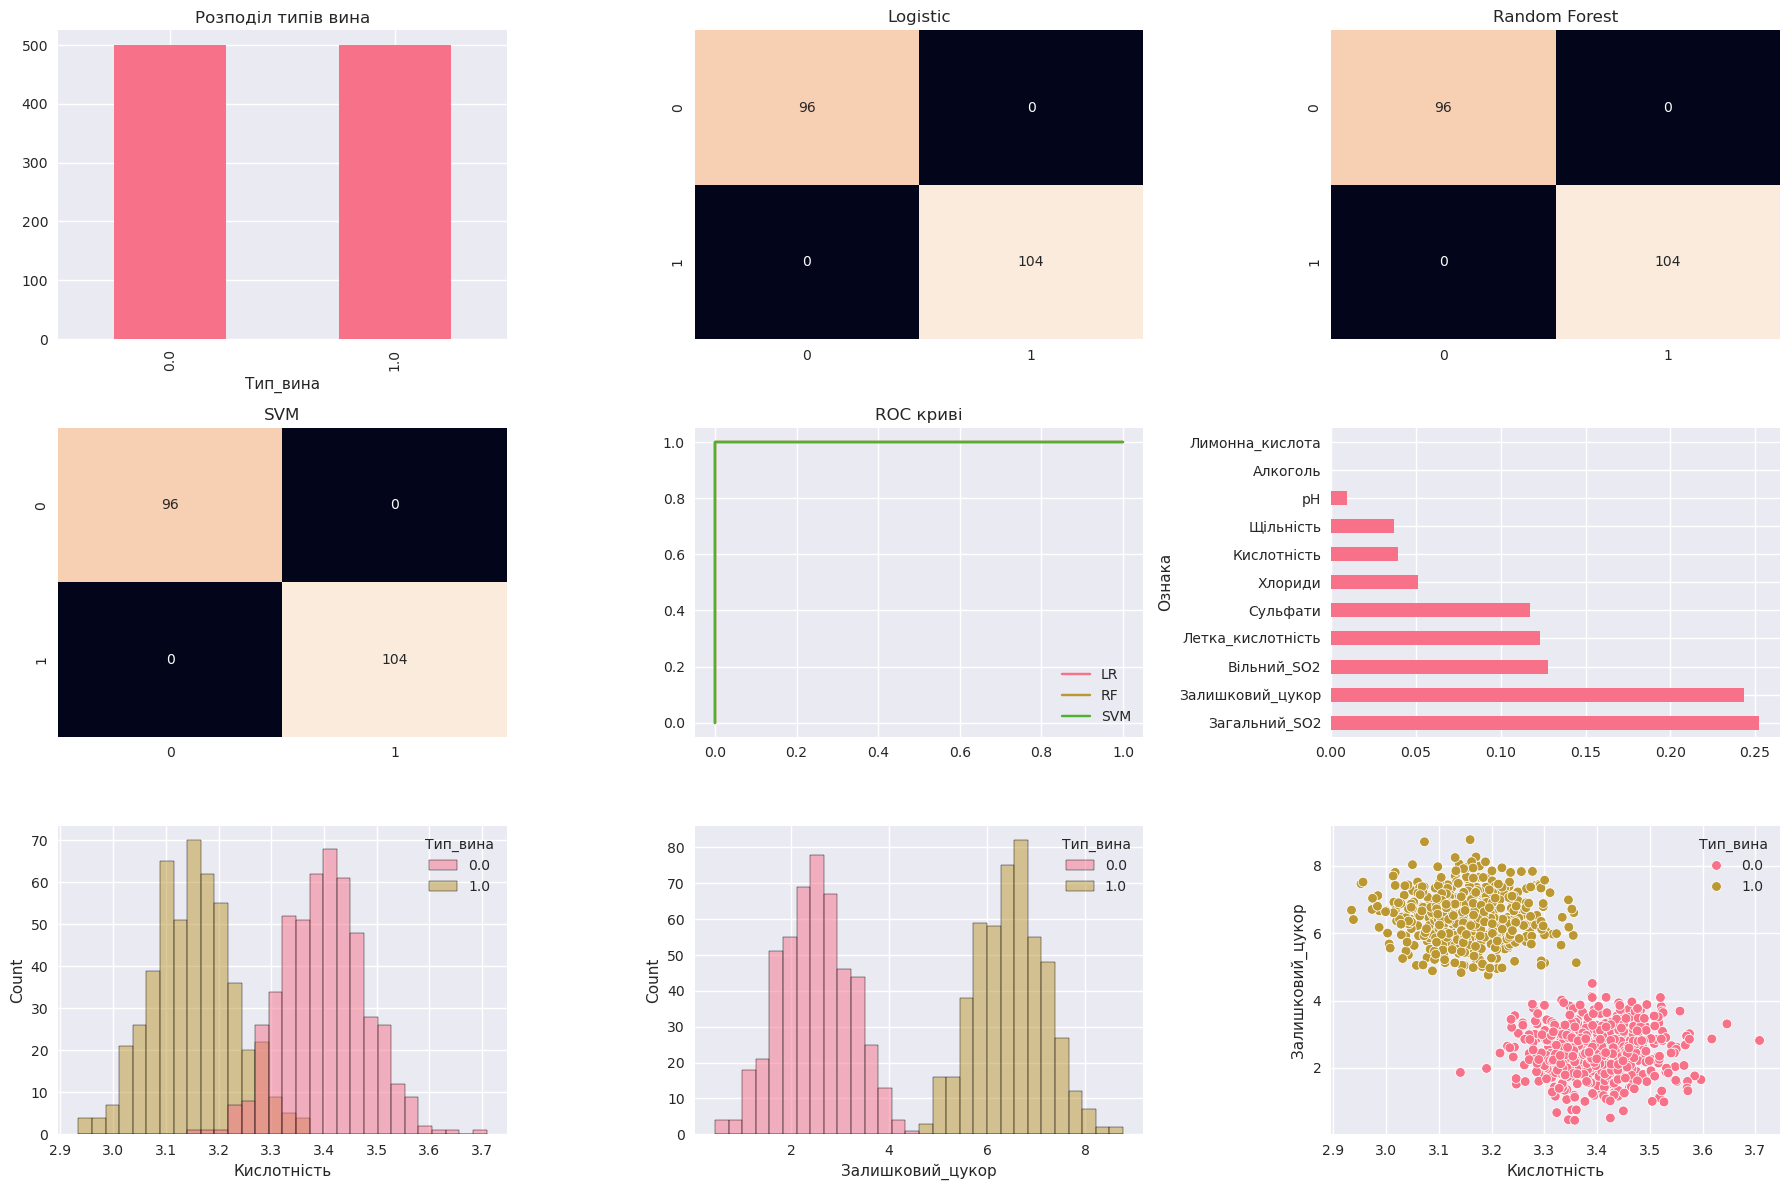


ПРОГНОЗ: БІЛЕ
Впевненість: 100.0 %


In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
)

plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")

#1:Генерація синтетичного датасету
np.random.seed(42)

n_red = 500
n_white = 500

def gen_feature(red_mean, white_mean, std):
    red = np.random.normal(red_mean, std, n_red)
    white = np.random.normal(white_mean, std, n_white)
    return np.concatenate([red, white])

data = {
    "Кислотність": gen_feature(3.4, 3.15, 0.08),
    "Летка_кислотність": gen_feature(0.5, 0.3, 0.05),
    "Лимонна_кислота": gen_feature(0.3, 0.35, 0.04),
    "Залишковий_цукор": gen_feature(2.5, 6.5, 0.7),
    "Хлориди": gen_feature(0.085, 0.045, 0.01),
    "Вільний_SO2": gen_feature(15, 40, 5),
    "Загальний_SO2": gen_feature(60, 150, 15),
    "Щільність": gen_feature(0.997, 0.994, 0.001),
    "pH": gen_feature(3.4, 3.2, 0.08),
    "Сульфати": gen_feature(0.65, 0.45, 0.05),
    "Алкоголь": gen_feature(10.5, 10.5, 0.4),
}

df = pd.DataFrame(data)
df["Тип_вина"] = np.concatenate([np.zeros(n_red), np.ones(n_white)])

#2: Дослідницький аналіз даних
print("Загальна кількість:", len(df))
print(df["Тип_вина"].value_counts())
print(df.head())
print(df.describe())
print(df.isnull().sum())

#3: Підготовка даних
X = df.drop("Тип_вина", axis=1)
y = df["Тип_вина"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#4: Навчання моделей
model_lr = LogisticRegression(max_iter=1000)
model_rf = RandomForestClassifier(n_estimators=150, random_state=42)
model_svm = SVC(kernel="rbf", probability=True)

model_lr.fit(X_train_scaled, y_train)
model_rf.fit(X_train_scaled, y_train)
model_svm.fit(X_train_scaled, y_train)

#5: прогнози
y_lr = model_lr.predict(X_test_scaled)
y_rf = model_rf.predict(X_test_scaled)
y_svm = model_svm.predict(X_test_scaled)

proba_lr = model_lr.predict_proba(X_test_scaled)[:, 1]
proba_rf = model_rf.predict_proba(X_test_scaled)[:, 1]
proba_svm = model_svm.predict_proba(X_test_scaled)[:, 1]

#6: оцінка
for name, y_pred in zip(
    ["Logistic", "Random Forest", "SVM"],
    [y_lr, y_rf, y_svm],
):
    print(f"\n{name}")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

feature_importance = pd.DataFrame({
    "Ознака": X.columns,
    "Важливість": model_rf.feature_importances_
}).sort_values("Важливість", ascending=False)

print(feature_importance)

#7: Графіки
plt.figure(figsize=(18, 12))

plt.subplot(3, 3, 1)
df["Тип_вина"].value_counts().plot(kind="bar")
plt.title("Розподіл типів вина")

#Матриці помилок - SVM
for i, (pred, title) in enumerate([
    (y_lr, "Logistic"),
    (y_rf, "Random Forest"),
    (y_svm, "SVM"),
]):
    plt.subplot(3, 3, i + 2)
    sns.heatmap(confusion_matrix(y_test, pred),
                annot=True, fmt="d", cbar=False)
    plt.title(title)

#ROC
plt.subplot(3, 3, 5)
for p, label in zip(
    [proba_lr, proba_rf, proba_svm],
    ["LR", "RF", "SVM"]
):
    fpr, tpr, _ = roc_curve(y_test, p)
    plt.plot(fpr, tpr, label=label)
plt.legend()
plt.title("ROC криві")

#Важливість ознак
plt.subplot(3, 3, 6)
feature_importance.plot(
    x="Ознака", y="Важливість", kind="barh",
    legend=False, ax=plt.gca()
)

#Розподіл кислотності за типами
plt.subplot(3, 3, 7)
sns.histplot(data=df, x="Кислотність", hue="Тип_вина", bins=30)

#Розподіл залишкового цукру
plt.subplot(3, 3, 8)
sns.histplot(data=df, x="Залишковий_цукор", hue="Тип_вина", bins=30)

#Scatter plot: Кислотність vs Цукор
plt.subplot(3, 3, 9)
sns.scatterplot(
    data=df,
    x="Кислотність",
    y="Залишковий_цукор",
    hue="Тип_вина",
)

plt.tight_layout()
plt.show()

#Частина 8: Прогноз (новий зразок)
new_wine = pd.DataFrame({
    "Кислотність": [3.2],
    "Летка_кислотність": [0.3],
    "Лимонна_кислота": [0.35],
    "Залишковий_цукор": [6.5],
    "Хлориди": [0.045],
    "Вільний_SO2": [40],
    "Загальний_SO2": [150],
    "Щільність": [0.994],
    "pH": [3.2],
    "Сульфати": [0.45],
    "Алкоголь": [10.5],
})

new_scaled = scaler.transform(new_wine)
pred = model_rf.predict(new_scaled)[0]
proba = model_rf.predict_proba(new_scaled)[0]

print("\nПРОГНОЗ:", "БІЛЕ" if pred == 1 else "ЧЕРВОНЕ")
print("Впевненість:", max(proba) * 100, "%")